In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error
import regex as re

# Loading dataset

In [2]:
df = pd.read_csv(r"C:\Users\swini\Desktop\Python\laptop_price\laptop_price.csv", encoding='latin-1', index_col='laptop_ID')

In [3]:
df.head()

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
laptop_ID,,,,,,,,,,,,
1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1303 entries, 1 to 1320
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           1303 non-null   object 
 1   Product           1303 non-null   object 
 2   TypeName          1303 non-null   object 
 3   Inches            1303 non-null   float64
 4   ScreenResolution  1303 non-null   object 
 5   Cpu               1303 non-null   object 
 6   Ram               1303 non-null   object 
 7   Memory            1303 non-null   object 
 8   Gpu               1303 non-null   object 
 9   OpSys             1303 non-null   object 
 10  Weight            1303 non-null   object 
 11  Price_euros       1303 non-null   float64
dtypes: float64(2), object(10)
memory usage: 132.3+ KB


# Data cleaning

In [5]:
f'{len(df[df.duplicated()]) * 100 / len(df):.2f}%'

'2.15%'

In [6]:
df = df.drop_duplicates()

# Feature engineering

## ScreenResolutions

In [7]:
df['ScreenResolution'].value_counts()

Full HD 1920x1080                                505
1366x768                                         263
IPS Panel Full HD 1920x1080                      226
IPS Panel Full HD / Touchscreen 1920x1080         51
Full HD / Touchscreen 1920x1080                   47
1600x900                                          23
Touchscreen 1366x768                              16
Quad HD+ / Touchscreen 3200x1800                  15
IPS Panel 4K Ultra HD 3840x2160                   12
IPS Panel 4K Ultra HD / Touchscreen 3840x2160     11
4K Ultra HD / Touchscreen 3840x2160               10
4K Ultra HD 3840x2160                              7
Touchscreen 2560x1440                              7
IPS Panel 1366x768                                 7
IPS Panel Retina Display 2560x1600                 6
IPS Panel Retina Display 2304x1440                 6
Touchscreen 2256x1504                              6
IPS Panel Touchscreen 2560x1440                    5
IPS Panel Quad HD+ / Touchscreen 3200x1800    

In [8]:
df['Resolution'] = df['ScreenResolution'].str.extract(r'(\d+x\d+)')

In [9]:
df['Touch_screen'] = df['ScreenResolution'].str.extract(r'(Touchscreen)',re.IGNORECASE).fillna(0)
df['Touch_screen']=df['Touch_screen'].replace("Touchscreen",1)

In [10]:
df['IPS Panel_screen'] = df['ScreenResolution'].str.extract(r'(IPS Panel)',re.IGNORECASE).fillna(0)
df['IPS Panel_screen']=df['IPS Panel_screen'].replace("IPS Panel",1)

In [11]:
df = df.drop('ScreenResolution', axis=1)

## CPU

In [12]:
df['Cpu'].value_counts()

Intel Core i5 7200U 2.5GHz     190
Intel Core i7 7700HQ 2.8GHz    146
Intel Core i7 7500U 2.7GHz     132
Intel Core i7 8550U 1.8GHz      73
Intel Core i5 8250U 1.6GHz      72
                              ... 
Intel Core M M3-6Y30 0.9GHz      1
AMD A9-Series 9420 2.9GHz        1
Intel Core i5 2.9GHz             1
AMD A6-Series 7310 2GHz          1
AMD A9-Series 9410 2.9GHz        1
Name: Cpu, Length: 118, dtype: int64

### Seperat Cpu brand and Cpu speed from Cpu column

In [13]:
split_vendor = df['Cpu'].str.split(' ', 1, expand=True)
split_vendor.head()

,0,1
laptop_ID,,
1,Intel,Core i5 2.3GHz
2,Intel,Core i5 1.8GHz
3,Intel,Core i5 7200U 2.5GHz
4,Intel,Core i7 2.7GHz
5,Intel,Core i5 3.1GHz


In [14]:
df['Cpu Brand'] = split_vendor[0]
df['Cpu'] = split_vendor[1]

In [15]:
df['Cpu'] = df['Cpu'].str.split()
df['Cpu Speed'] = df['Cpu'].str.get(-1)

In [16]:
temp = list(df['Cpu'])
temp_2 = []
for i in temp:
    del i[-1]
    temp_2.append(i)
temp_3 = []
for i in temp_2:
    temp_3.append(" ".join(i))
df['Cpu'] = temp_3

In [17]:
df['Cpu Speed'] = df['Cpu Speed'].replace('[GHz]', '', regex=True)
df['Cpu Speed'] = pd.to_numeric(df['Cpu Speed'])
df.rename(columns={'Cpu Speed':'Cpu Speed (GHz)'}, inplace=True)

## Ram

In [18]:
df['Ram'].value_counts()

8GB     613
4GB     367
16GB    198
6GB      35
12GB     25
32GB     17
2GB      16
24GB      3
64GB      1
Name: Ram, dtype: int64

In [19]:
df['Ram'] = df['Ram'].replace('GB', '', regex= True).astype('int')
df.rename(columns = {'Ram':'Ram [GB]'}, inplace = True)

## Memory

In [20]:
df['Memory'].value_counts()

256GB SSD                        412
1TB HDD                          215
500GB HDD                        124
512GB SSD                        114
128GB SSD +  1TB HDD              94
128GB SSD                         74
256GB SSD +  1TB HDD              73
32GB Flash Storage                36
2TB HDD                           16
512GB SSD +  1TB HDD              14
1TB SSD                           14
64GB Flash Storage                13
256GB SSD +  2TB HDD              10
256GB Flash Storage                8
16GB Flash Storage                 7
1.0TB Hybrid                       7
32GB SSD                           6
180GB SSD                          5
128GB Flash Storage                4
512GB SSD +  2TB HDD               3
16GB SSD                           3
512GB Flash Storage                2
1TB SSD +  1TB HDD                 2
256GB SSD +  500GB HDD             2
128GB SSD +  2TB HDD               2
256GB SSD +  256GB SSD             2
512GB SSD +  256GB SSD             1
5

### Separate memory type and memory capacity from Memory column

#### Recognise memory type and memory capacity to save it as dictionary

In [21]:
def memory_type_finder(memory):
  result = {'SSD' : [],
            'HDD' : [],
            'Flash' : [],
            'Hybrid' : []}

  for mem in memory:
    mem = mem.split()
    if 'SSD' in mem:
      result['SSD'].append(mem[mem.index('SSD')-1])
      
    else:
      result['SSD'].append('0')
      
    if 'HDD' in mem:
      result['HDD'].append(mem[mem.index('HDD')-1])
    
    else:
      result['HDD'].append('0')

    if 'Flash' in mem:
      result['Flash'].append(mem[mem.index('Flash')-1])
      
    else:
      result['Flash'].append('0')

    if 'Hybrid' in mem:
      result['Hybrid'].append(mem[mem.index('Hybrid')-1])
      
    else:
      result['Hybrid'].append('0')

  return result

In [22]:
memory_dict = memory_type_finder(df.Memory.tolist())

#### Make DataFrame from memory dictionary

In [23]:
df2 = pd.DataFrame(memory_dict, index=df.index)

In [24]:
df2.head()

,SSD,HDD,Flash,Hybrid
laptop_ID,,,,
1,128GB,0,0,0
2,0,0,128GB,0
3,256GB,0,0,0
4,512GB,0,0,0
5,256GB,0,0,0


#### Change data's format and add new memory columns to main DataFrame

In [25]:
def memory_unit_changer(memory):
  memory=str(memory)
  if 'GB' in memory:
    memory = re.sub('GB', '', memory)
  elif 'TB' in memory:
    memory = re.sub('.0', '', memory)
    memory = re.sub('TB', '000', memory)
    
  return int(memory)

In [26]:
cols = ['SSD', 'HDD', 'Flash', 'Hybrid']

for col in cols:
    df[col] = df2[col].apply(memory_unit_changer)

In [27]:
df.drop('Memory', inplace=True, axis=1)

## Weight


In [28]:
df['Weight'].replace('kg', '', regex= True, inplace= True)
df['Weight'] = df['Weight'].astype('float')

# Data Analysis

In [29]:
sns.set(rc={"axes.facecolor":"#FAF3FC","figure.facecolor":"#FAF3FC",'figure.figsize':(24,10)})

pallet = ["#e1d9d0","#be9b7b","#854442","#4b3832"]

Text(0.5, 1.0, 'Laptop Price by Company')

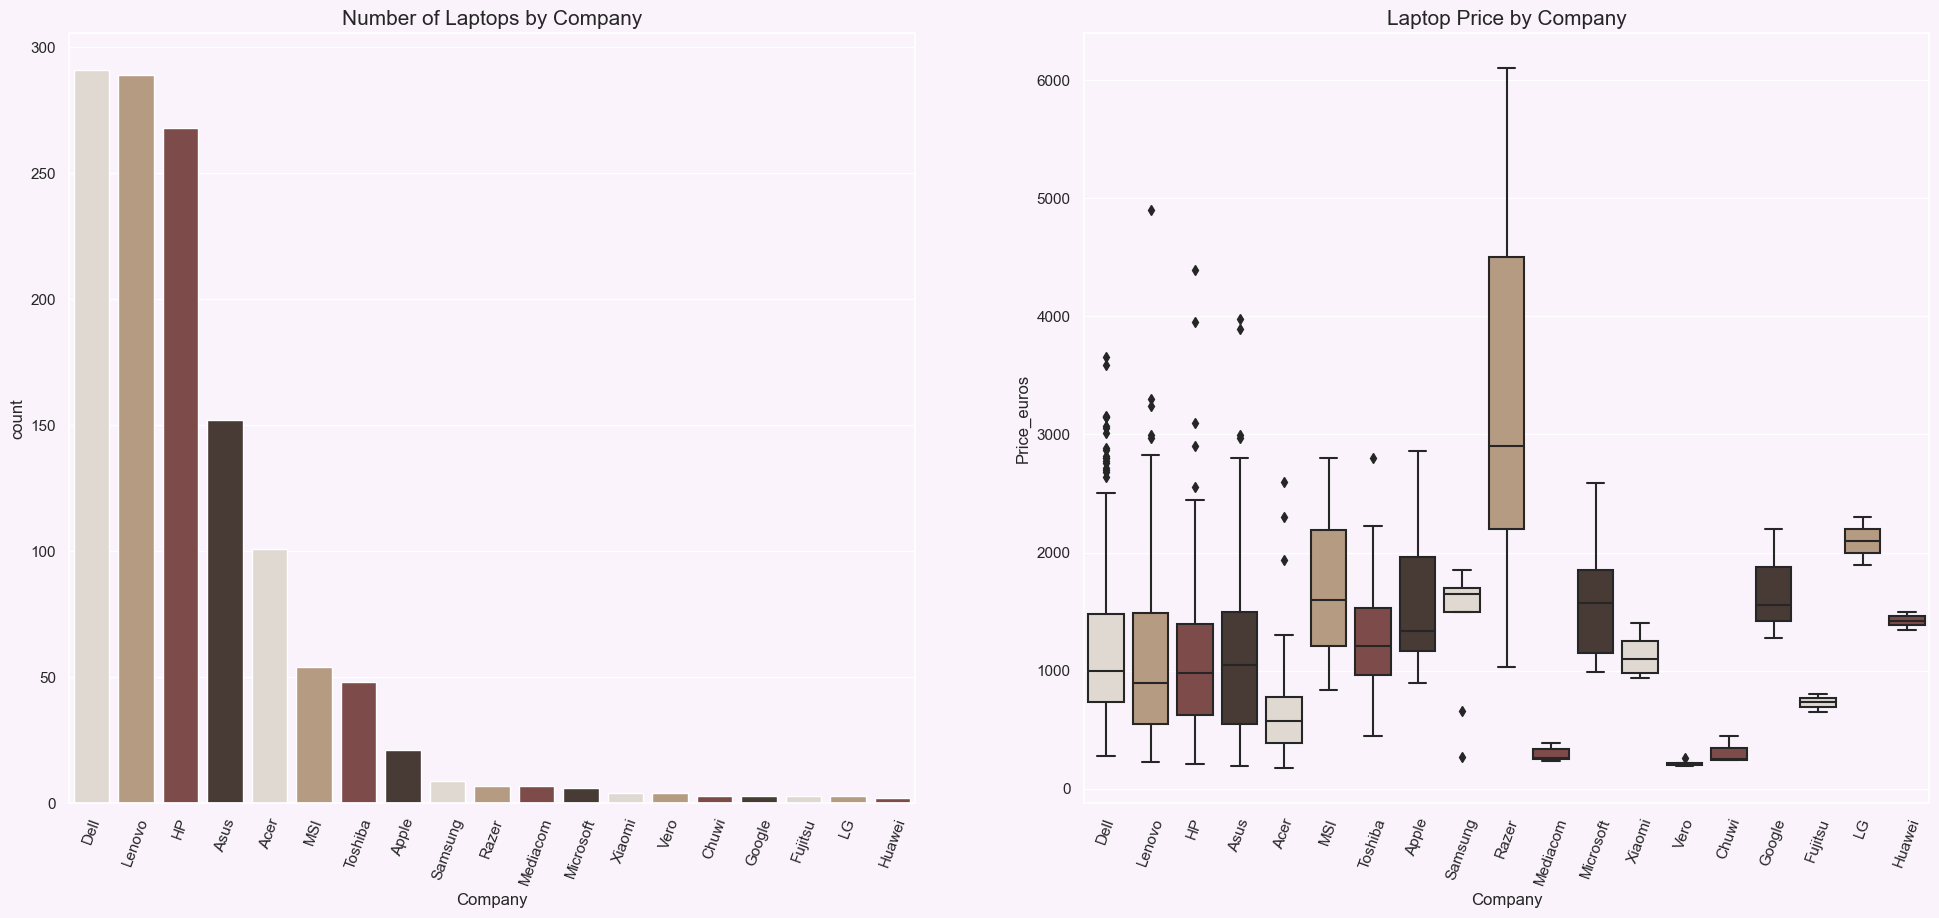

In [30]:
fig, axes = plt.subplots(1,2)
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=70)

sns.countplot(x="Company", ax=axes[0], palette=pallet, data=df, order=df["Company"].value_counts().index)
sns.boxplot(x="Company", y="Price_euros", palette=pallet, data=df, order=df["Company"].value_counts().index)

axes[0].set_title("Number of Laptops by Company", fontsize=15)
axes[1].set_title("Laptop Price by Company", fontsize=15)

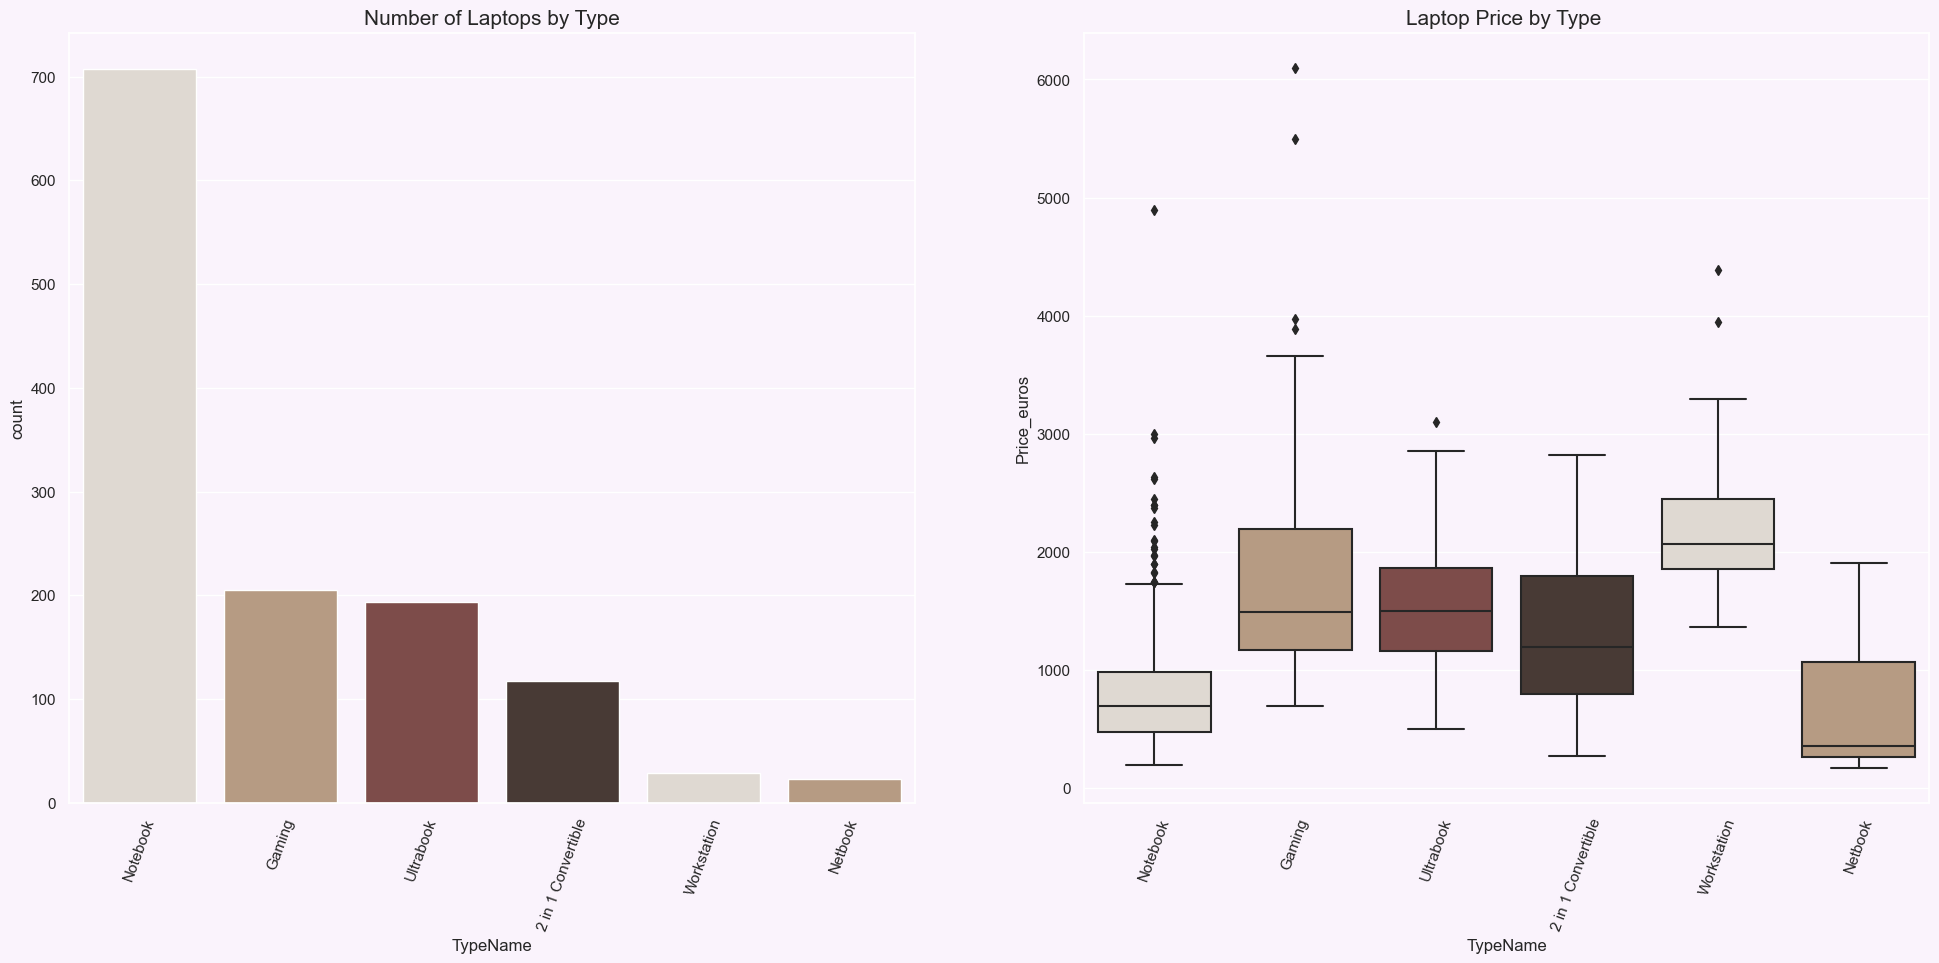

In [31]:
fig, axes = plt.subplots(1,2)
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=70)

sns.countplot(x="TypeName", ax=axes[0], palette=pallet, data=df, order=df["TypeName"].value_counts().index)
sns.boxplot(x="TypeName", y='Price_euros' ,ax=axes[1], palette=pallet, data=df, order=df["TypeName"].value_counts().index)

axes[0].set_title("Number of Laptops by Type", fontsize=15)
axes[1].set_title("Laptop Price by Type ", fontsize=15)
plt.show()

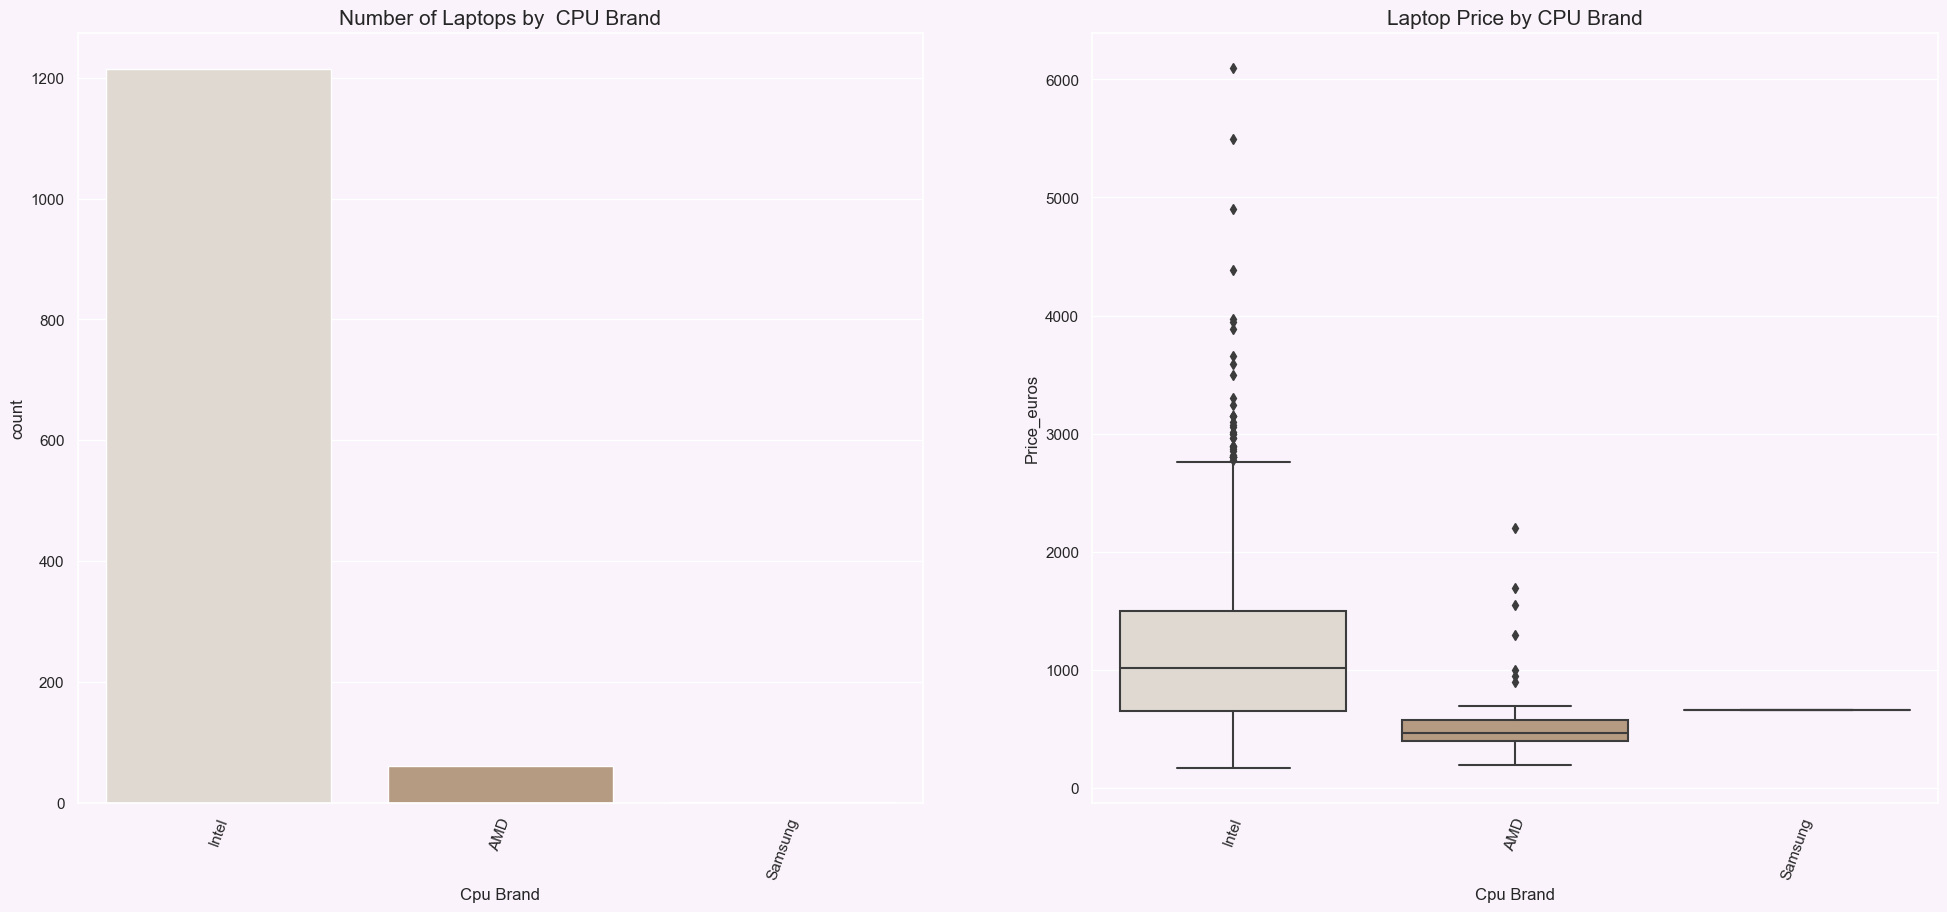

In [32]:
fig, axes = plt.subplots(1,2)
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=70)

sns.countplot(x="Cpu Brand",ax=axes[0],palette=pallet,data=df,order=df["Cpu Brand"].value_counts().index)
sns.boxplot(x ="Cpu Brand",y ="Price_euros" ,palette=pallet,ax=axes[1],data = df)

axes[0].set_title("Number of Laptops by  CPU Brand",fontsize=15)
axes[1].set_title("Laptop Price by CPU Brand",fontsize=15)


plt.show()

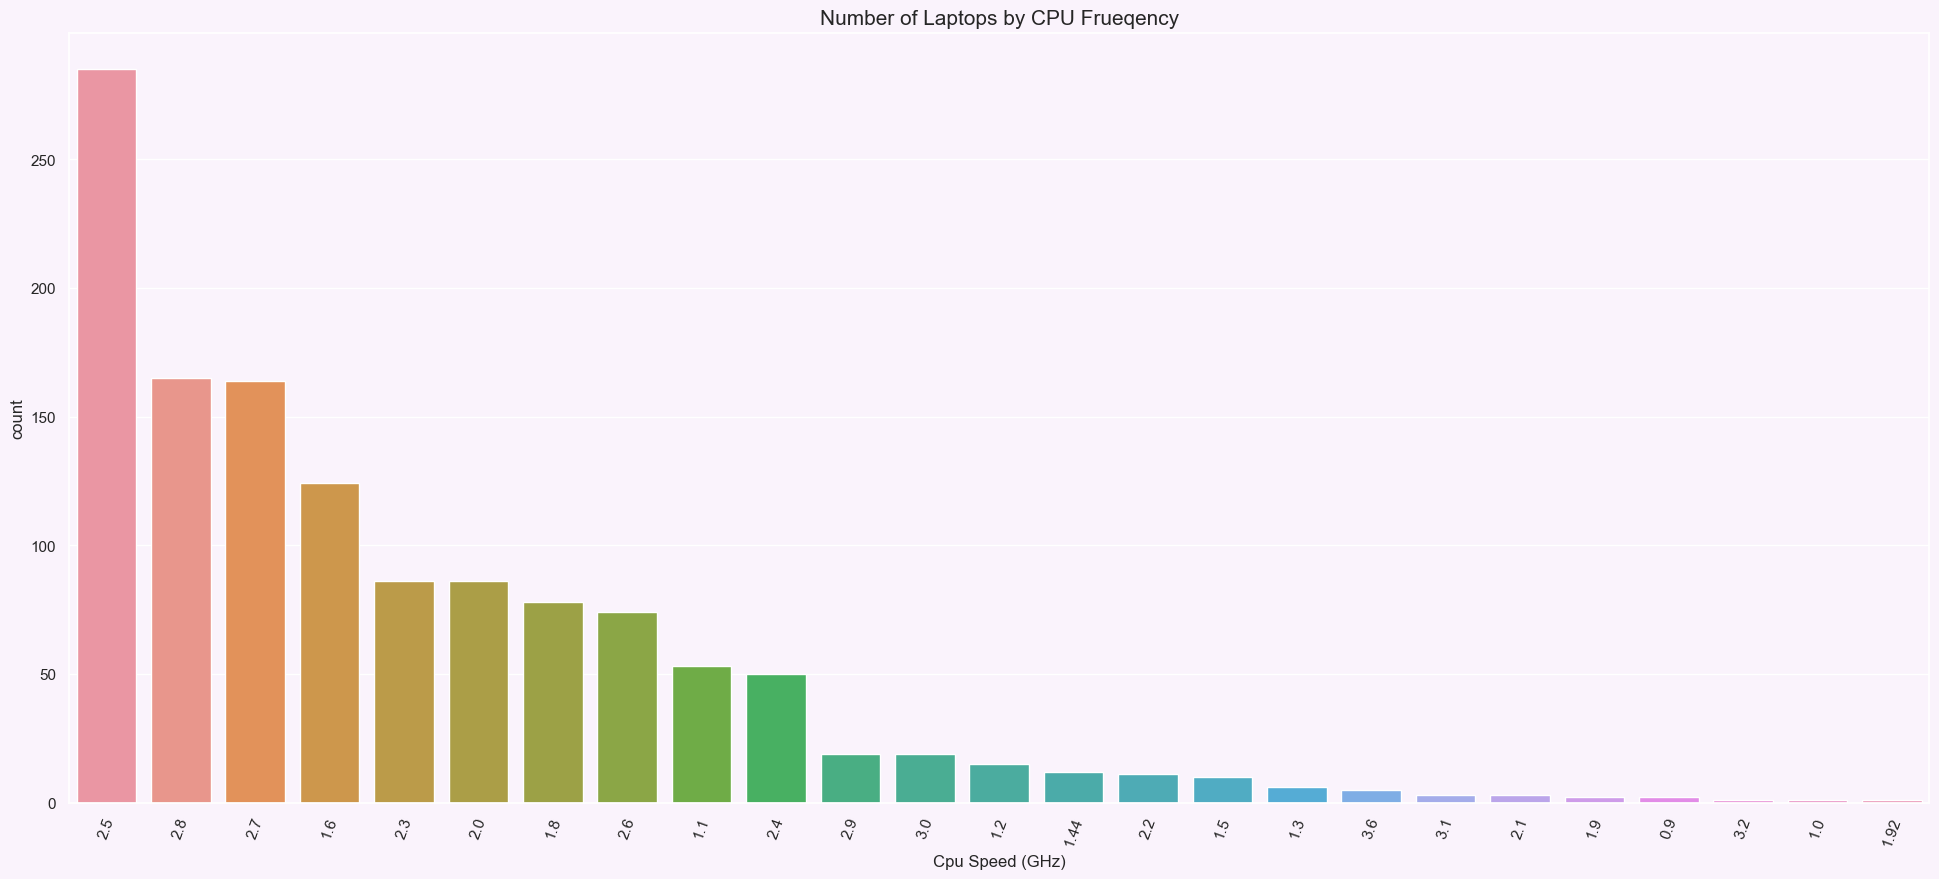

In [33]:
fig, axes = plt.subplots()
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=70)

sns.countplot(x="Cpu Speed (GHz)",ax=axes,data=df,order=df["Cpu Speed (GHz)"].value_counts().index)

axes.set_title("Number of Laptops by CPU Frueqency",fontsize=15)

plt.show()

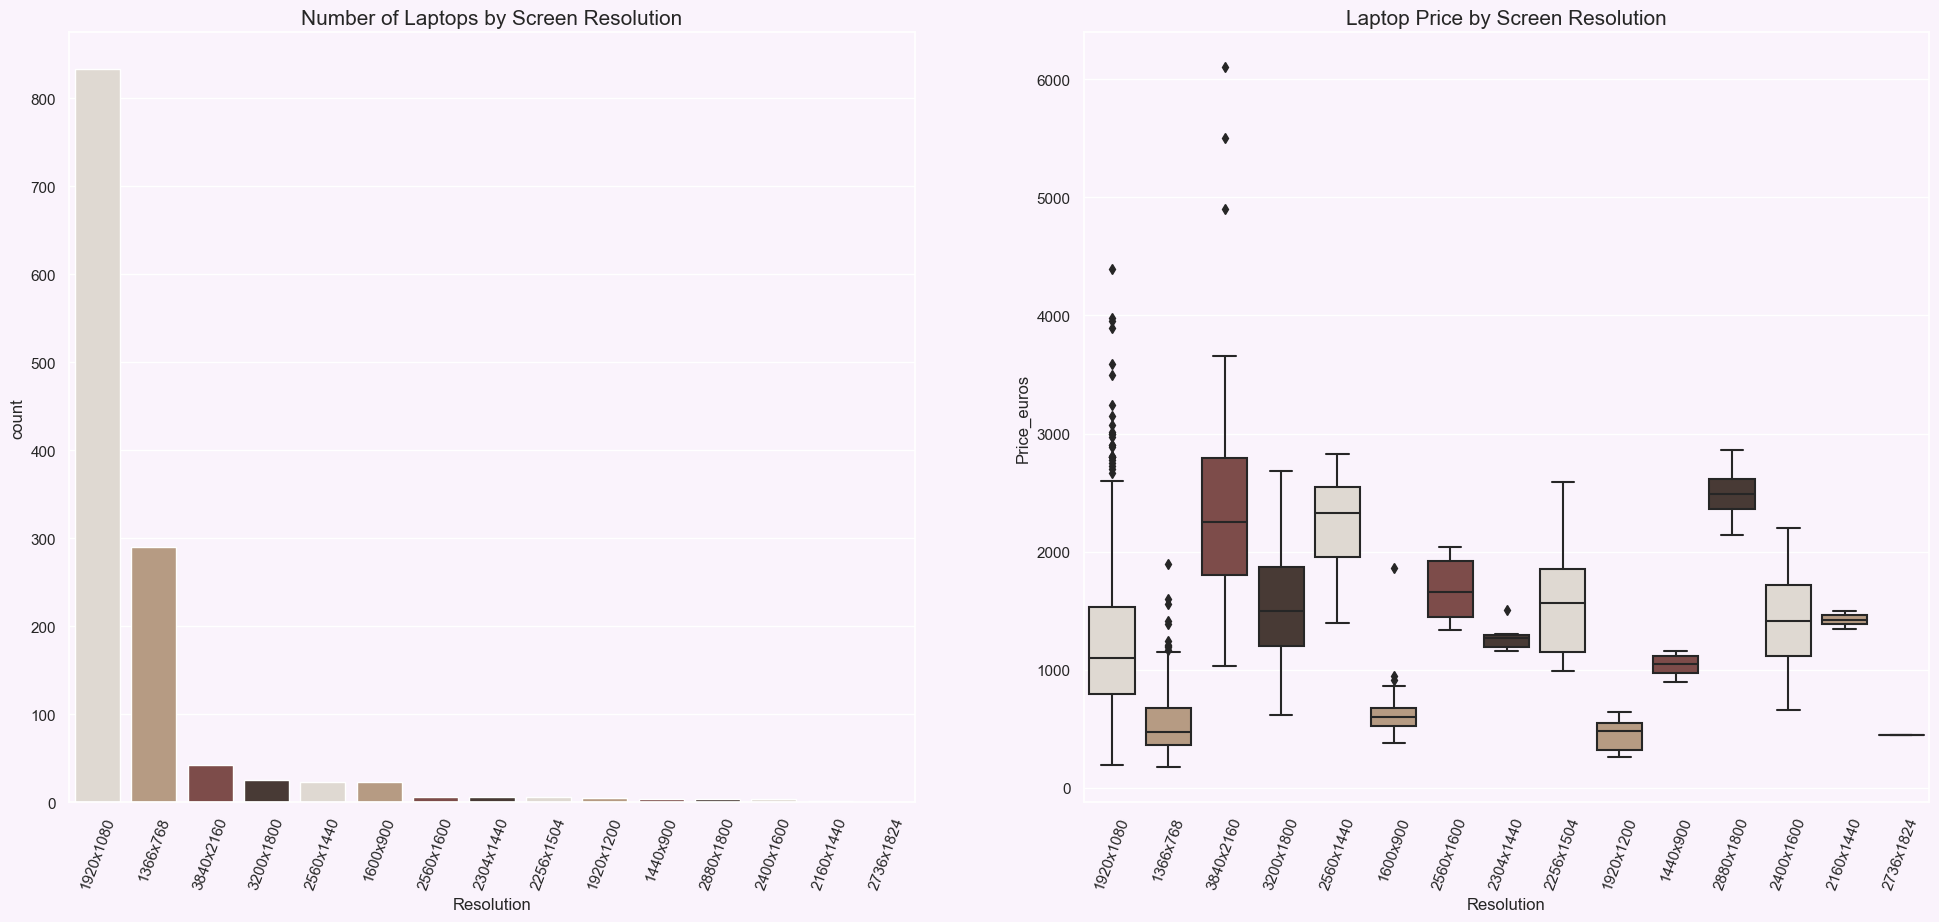

In [34]:
fig, axes = plt.subplots(nrows=1, ncols=2)
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=70)

sns.countplot(x="Resolution", ax=axes[0], palette=pallet, order=df["Resolution"].value_counts().index, data=df)
sns.boxplot(x="Resolution", y='Price_euros', ax=axes[1], palette=pallet, order=df["Resolution"].value_counts().index, data = df)
axes[0].set_title("Number of Laptops by Screen Resolution",fontsize=15)
axes[1].set_title("Laptop Price by Screen Resolution",fontsize=15)

plt.show()

Text(0.5, 1.0, 'Laptop Price by Ram capacity')

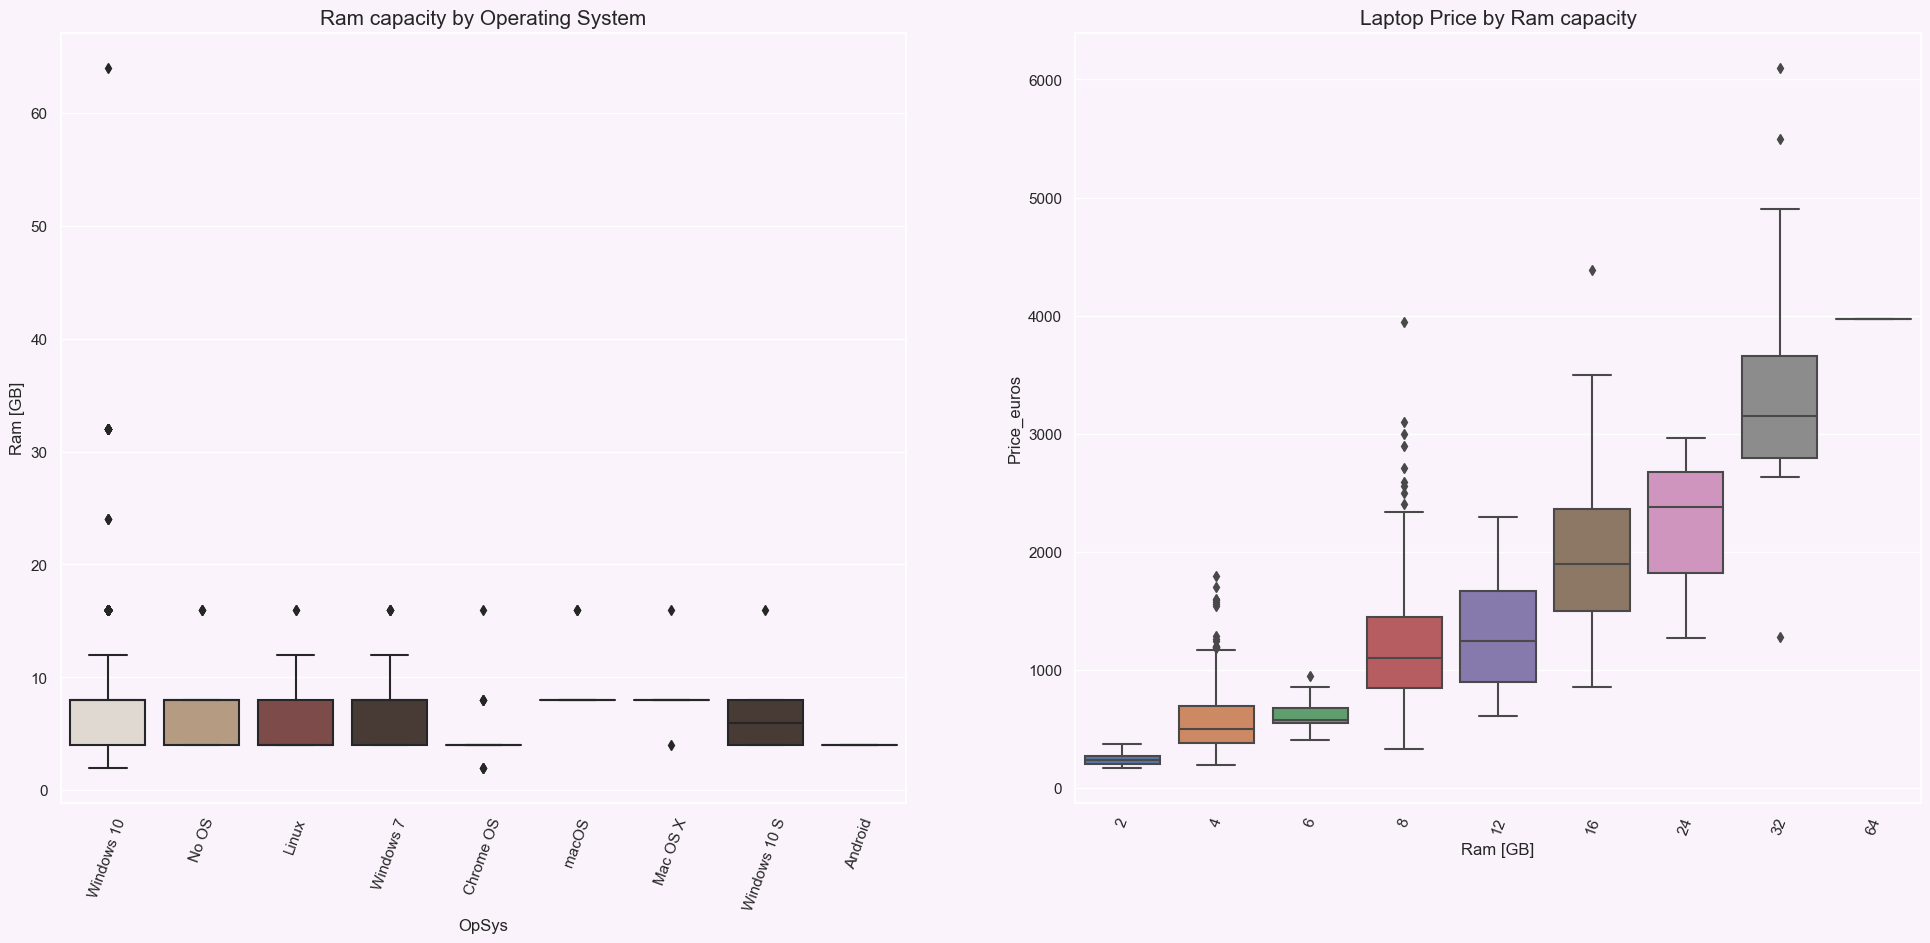

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=2)
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=70)
    
    
sns.boxplot(x="OpSys", y="Ram [GB]", ax=axes[0], palette=pallet, order=df["OpSys"].value_counts().index, data=df)
sns.boxplot(x='Ram [GB]', y='Price_euros', ax=axes[1], data=df)
axes[0].set_title("Ram capacity by Operating System", fontsize=15)
axes[1].set_title("Laptop Price by Ram capacity", fontsize=15)

Text(0.5, 1.0, 'Laptop Price by Operating System')

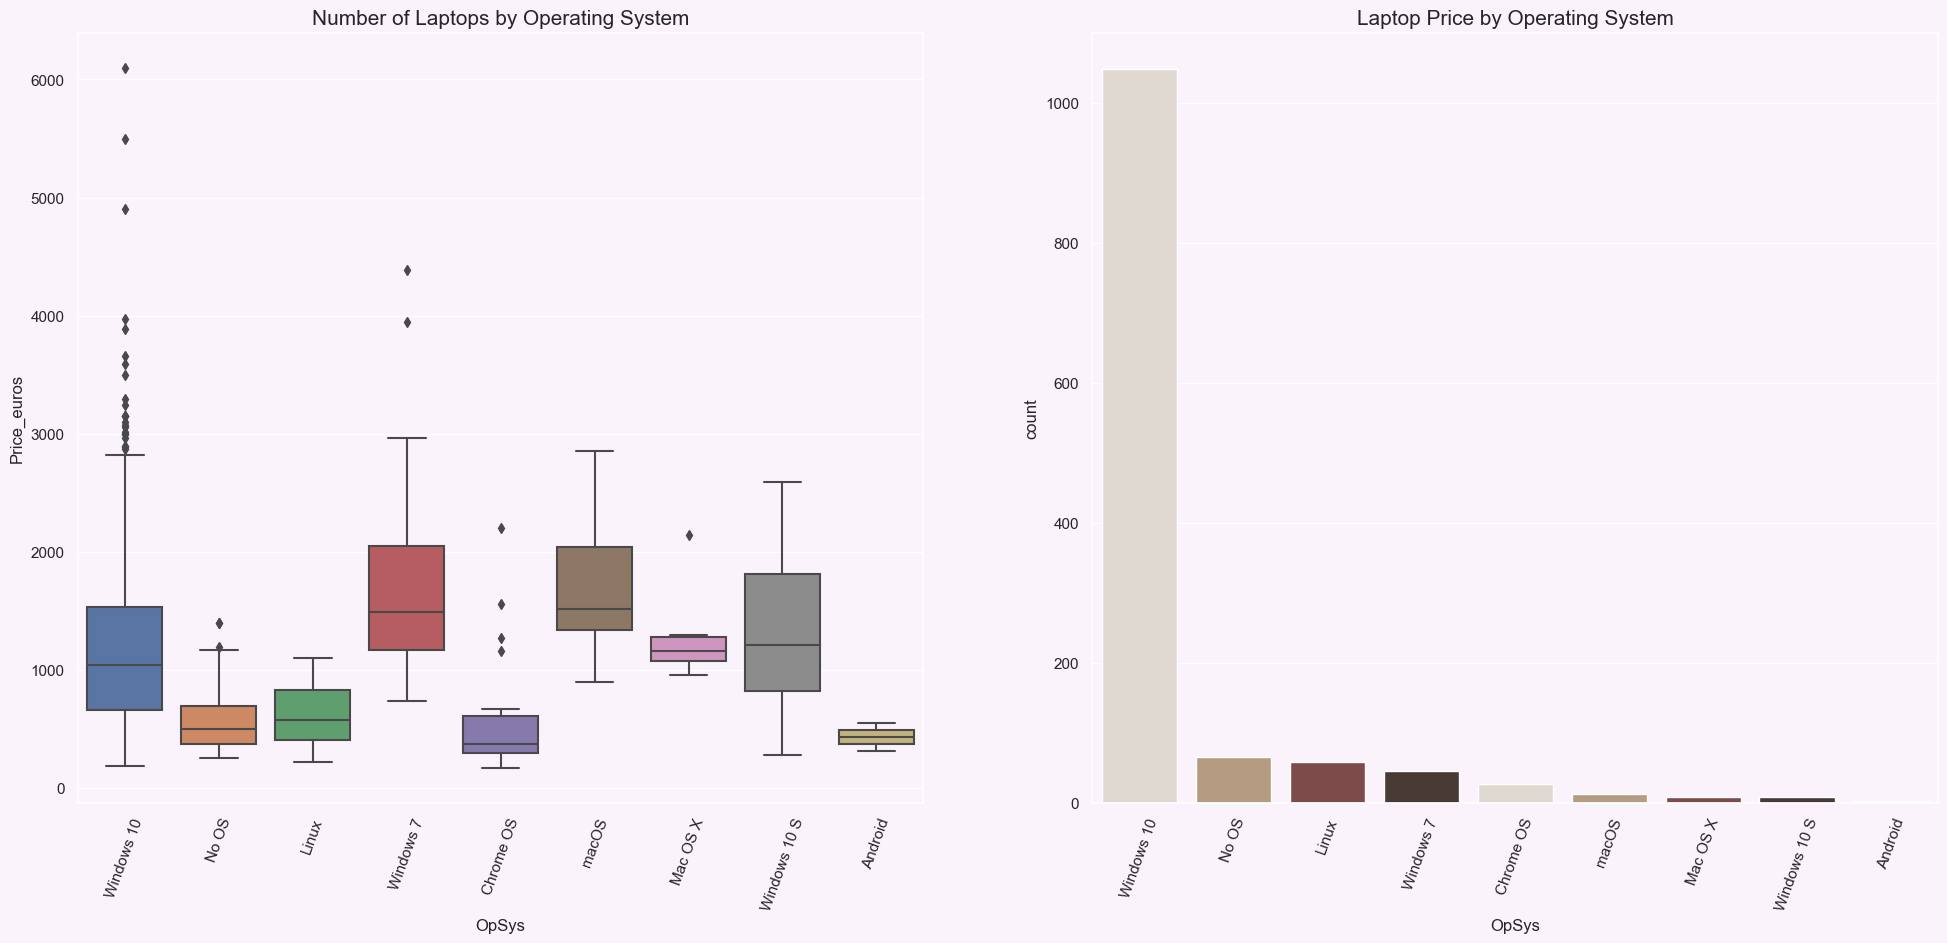

In [36]:
fig, axes = plt.subplots(nrows=1, ncols=2)
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=70)

sns.boxplot(x='OpSys', y='Price_euros', ax=axes[0], data=df, order=df["OpSys"].value_counts().index)
sns.countplot(x="OpSys", ax=axes[1], palette=pallet, data = df, order=df["OpSys"].value_counts().index)
axes[0].set_title("Number of Laptops by Operating System", fontsize=15)
axes[1].set_title("Laptop Price by Operating System", fontsize=15)

# Regresja

In [37]:
from sklearn.preprocessing import LabelEncoder
cols = ['OpSys', 'Resolution', 'Cpu Brand', 'Company', 'Product', 'TypeName', 'Cpu', 'Gpu']

for col in cols:
    df[col] = LabelEncoder().fit_transform(df[col])

<AxesSubplot:>

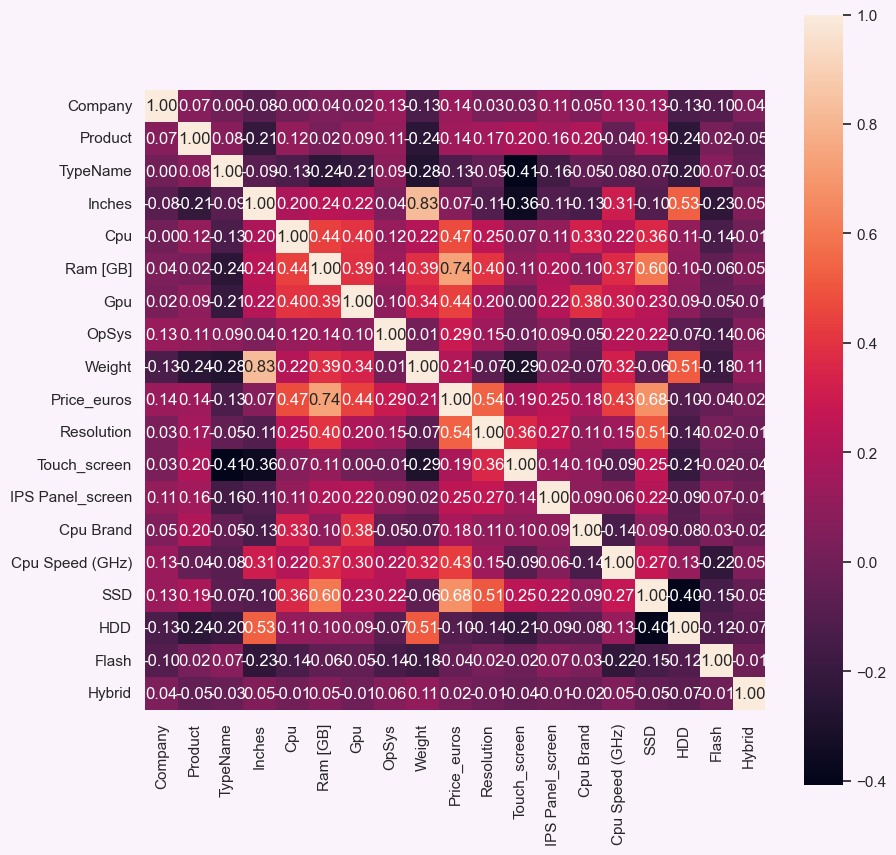

In [38]:
corr_matrix = np.corrcoef(df.values.T)
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(data=corr_matrix,
            annot=True,
            square = True,
            fmt='.2f',
            xticklabels=df.columns,
            yticklabels=df.columns)

In [39]:
X = df[['Cpu', 'TypeName', 'Ram [GB]', 'Gpu', 'Weight', 'Resolution', 'IPS Panel_screen', 'Cpu Speed (GHz)', 'SSD', 'HDD']]
y = df['Price_euros'].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
cv = KFold(n_splits=15, random_state=1, shuffle=True)
model = LinearRegression()
scores_cv = pd.Series(cross_val_score(model, X_train, y_train, scoring='r2', cv=cv))

<AxesSubplot:>

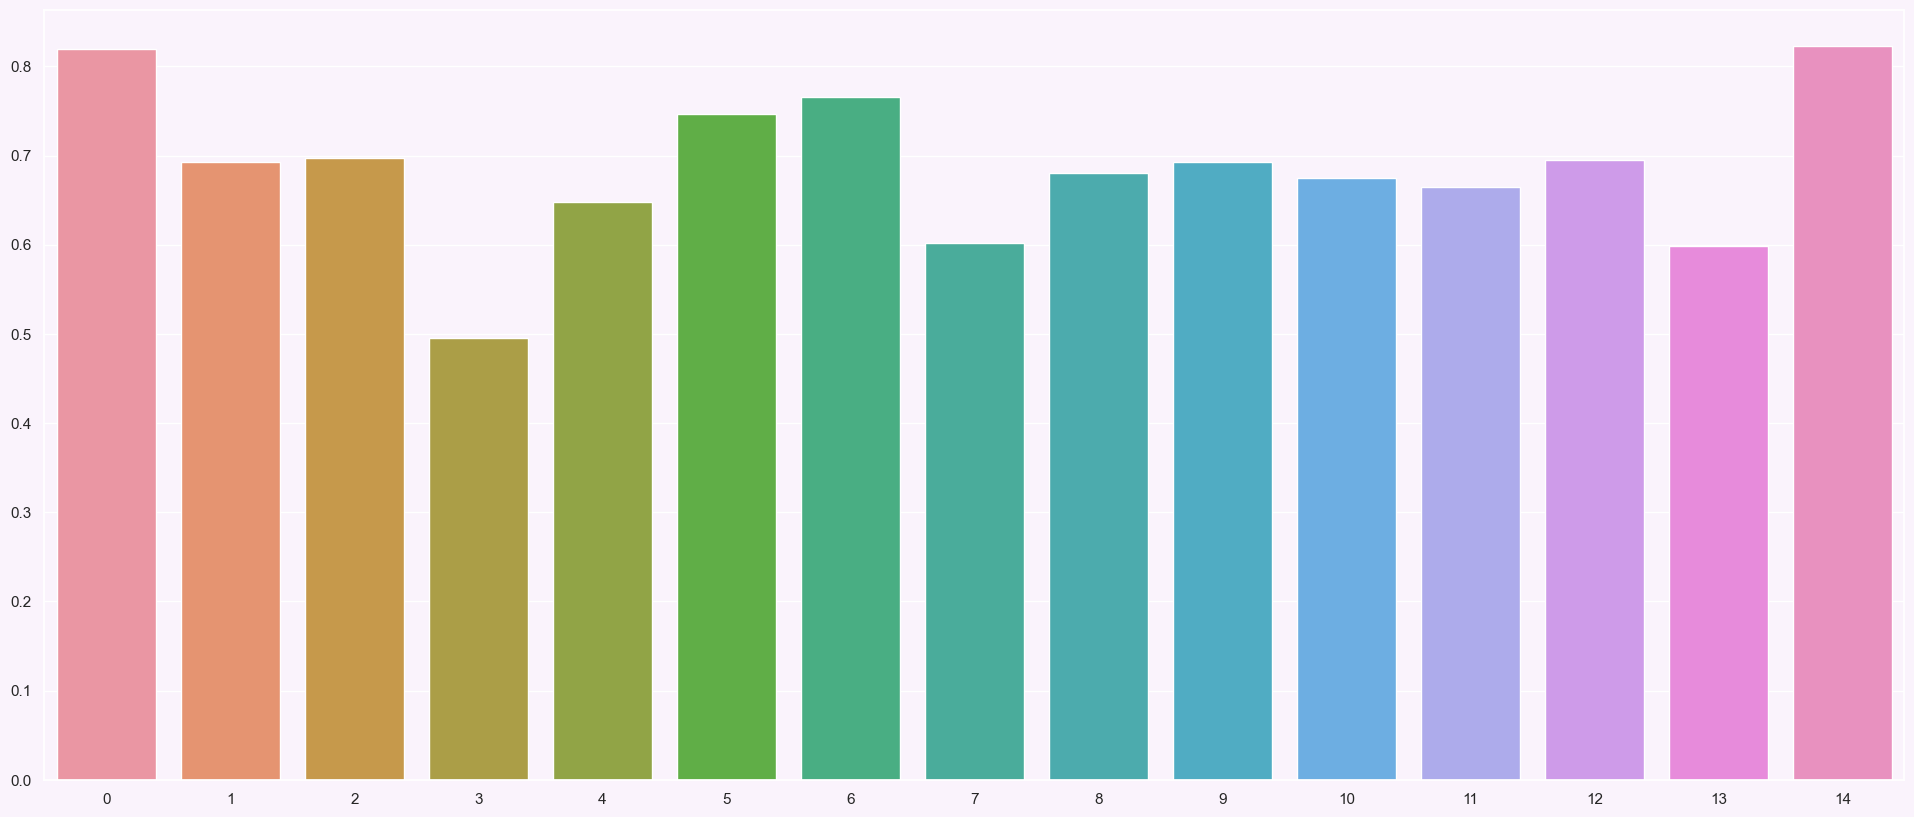

In [40]:
sns.barplot(x=scores_cv.index, y=scores_cv)

In [41]:
scores_cv.describe()

count    15.000000
mean      0.686127
std       0.084287
min       0.495454
25%       0.655748
50%       0.692361
75%       0.721571
max       0.822252
dtype: float64

In [42]:
model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.7307406000933371